In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import pandas as pd
import re

description_df = pd.DataFrame(columns = ['Job Description', 'Job Link'])
job_df = pd.DataFrame(columns = ['Company', 'Job Title', 'Job Link'])

def linkedin_scraper(webpage, page_number):
    next_page = webpage + str(page_number)
    response = requests.get(str(next_page))
    soup = BeautifulSoup(response.content,'html.parser')

    jobs = soup.find_all('div', class_='base-card relative w-full hover:no-underline focus:no-underline base-card--link base-search-card base-search-card--link job-search-card')
    job_data = []
    for job in jobs:
        job_title = job.find('h3', class_='base-search-card__title').text.strip()
        job_link = job.find('a', class_='base-card__full-link')['href']
        job_company = job.find('a', class_='hidden-nested-link').text.strip()

        job_data.append({'Company': job_company, 'Job Title': job_title, 'Job Link': job_link})
    global job_df
    job_df = pd.concat([job_df, pd.DataFrame(job_data)], ignore_index=True)
    print('Data updated')

def get_description(webpage, page_number):
    next_page = webpage + str(page_number)
    response = requests.get(str(next_page))
    soup = BeautifulSoup(response.content,'html.parser')
    url_deep = []
    description_data = []

    for a in soup.find_all('a', class_='base-card__full-link absolute top-0 right-0 bottom-0 left-0 p-0 z-[2]',href=True):
        url_deep.append(a['href'])

    for u in url_deep:
        # Make a request to the second page
        response_deep = requests.get(u)

        # Find all description elements
        sub_soup = BeautifulSoup(response_deep.content, features="lxml")
        descr = sub_soup.find("div", {"class": "description__text description__text--rich"})

        if descr is not None:
            description_data.append({'Job Description': descr.text, 'Job Link': u})
        else:
            print(f"Job description not found for {u}")

    global description_df
    description_df = pd.concat([description_df, pd.DataFrame(description_data)], ignore_index=True)
    return description_df 


def start_scraping(webpage, page_number, max_pages):
    job_df = pd.DataFrame(columns = ['Company', 'Job Title', 'Job Link'])
    job_df = linkedin_scraper(webpage, page_number)
    description_df = pd.DataFrame(columns = ['Job Description', 'Job Link'])
    description_df = get_description(webpage, page_number)
    if page_number == 0:
        all_jobs = job_df
        all_descriptions = description_df
    else:
        try:
            all_jobs
        except NameError:
            all_jobs = job_df
        else:
            all_jobs = pd.concat([all_jobs, job_df], ignore_index=True)
        try:
            all_descriptions
        except NameError:
            all_descriptions = description_df
        else:
            all_descriptions = pd.concat([all_descriptions, description_df], ignore_index=True)
    if page_number < max_pages:
        start_scraping(webpage, page_number + 25, max_pages)
    else:
        print('File closed')

start_scraping('https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Product%20Management&location=San%20Francisco%20Bay%20Area&geoId=90000084&trk=public_jobs_jobs-search-bar_search-submit&position=1&pageNum=0&start=', 0, 1000)       

def join_dataframes(job_df, description_df):

    description_df = description_df.drop_duplicates().reset_index().drop(columns = 'index')
    merged_df = job_df.merge(description_df, left_index=True, right_index=True)

    return merged_df

merged_df = join_dataframes(job_df, description_df)


Data updated
Data updated
Data updated
Job description not found for https://www.linkedin.com/jobs/view/product-manager-finance-at-headkount-2796288249?refId=Yh3RS7MrsAra0ypVZFlW2Q%3D%3D&trackingId=tr%2Bya42%2FbQsjxoc3C3dqUA%3D%3D&position=14&pageNum=2&trk=public_jobs_jserp-result_search-card
Job description not found for https://www.linkedin.com/jobs/view/staff-product-manager-customer-portal-and-experience-at-nium-3494481612?refId=Yh3RS7MrsAra0ypVZFlW2Q%3D%3D&trackingId=irIlvrAnNSlPBLU4XRhnLg%3D%3D&position=24&pageNum=2&trk=public_jobs_jserp-result_search-card
Data updated
Job description not found for https://www.linkedin.com/jobs/view/sr-manager-product-marketing-at-amd-3496453474?refId=szwddk6RMnrkNb9nSa%2FfLw%3D%3D&trackingId=%2BJREwOUB8KDG8dp7RisK3A%3D%3D&position=2&pageNum=3&trk=public_jobs_jserp-result_search-card
Data updated
Data updated
Data updated
Data updated
Job description not found for https://www.linkedin.com/jobs/view/scrum-master-project-manager-at-fortanix-3502535

In [2]:
# having merged_df it would be great to now start doing somethign with the descriptions themselves; not just in combination with our reddit scraping

# let's drop unnecessary job link column

merged_df.drop(columns = 'Job Link_y', inplace = True)

# now let's start cleaning our description

def clean_text(df):

    df['Preprocessed Descriptions'] = ""

    for index, row in df.iterrows():

        # Get the description text from the current row
        description = row['Job Description']

        # Remove URLs
        description = re.sub(r'http\S+', '', description)

        # remove punctuation
        description = re.sub(r'[^\w\s\d]', ' ', description)

        # Remove non-ASCII characters
        description = description.encode('ascii', 'ignore').decode()

        # Remove phrases that are not impactful to the analysis
        description = re.sub(r'Show less|Show more|Description|Company description', '', description)

        # Normalize currency symbols
        description = re.sub(r"(\d+(?:\.\d+)?)(\s?)(\$|€|USD|EUR)(\s?)", r"\1 \3", description)
        description = re.sub(r"\b(\d+(?:\.\d+)?) ?(\$|USD|EUR|€)\b", r"\1 \2", description)
        description = re.sub(r"(\$|USD)\s*(\d+(?:\.\d+)?)", r"\2 \1", description)
        description = re.sub(r"(\d+(?:\.\d+)?) ?(USD|EUR|€)", r"\1 \2", description)
        description = re.sub(r"(USD|EUR|€)\s*(\d+(?:\.\d+)?)", r"\2 \1", description)
        description = re.sub(r"\b(\$|USD|EUR|€)\b", "USD", description)

        # Separate words that got entangled together
        description = re.sub(r'([a-z])([A-Z])', r'\1 \2', description)

        # replace double space

        while "  " in description: 
            description = description.replace("  ", " ")

        # Update the preprocessed description in the dataframe
        df.at[index, 'Preprocessed Descriptions'] = description
    

    return df

df_cleaned = clean_text(merged_df)

In [3]:
# let's rename the job link column and drop unnecessary job description
df_cleaned.rename(columns = {'Job Link_x': 'Job Link'}, inplace = True)
# df_cleaned.drop(columns = 'Job Description', inplace = True)

# lets also remove stopwords 

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df_cleaned['Preprocessed Descriptions'] = df_cleaned['Preprocessed Descriptions'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaczm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.corpora import Dictionary
from gensim.models import LdaModel
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Load your preprocessed job description data from your DataFrame
descriptions = df_cleaned['Preprocessed Descriptions'].tolist()

tokenized_descriptions = []

for description in descriptions:
    tokens = word_tokenize(description)
    tokenized_descriptions.append(tokens)

# Convert the preprocessed descriptions to a document-term matrix
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
doc_term_matrix = vectorizer.fit_transform(descriptions)

# Fit a topic model to the document-term matrix
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(doc_term_matrix)

# Evaluate the topic model using perplexity score
print("Perplexity score:", lda.perplexity(doc_term_matrix))


# Interpret the results of the topic model
dictionary = Dictionary(tokenized_descriptions) # create the dictionary object
corpus = [dictionary.doc2bow(text) for text in tokenized_descriptions] # create the corpus object
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42)
topics = lda_model.show_topics(num_topics=10, num_words=10)
for topic in topics:
    print(topic)









[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaczm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Perplexity score: 1334.807613673221
(0, '0.010*"product" + 0.006*"experience" + 0.006*"team" + 0.005*"We" + 0.005*"skills" + 0.005*"management" + 0.004*"business" + 0.004*"new" + 0.004*"including" + 0.004*"work"')
(1, '0.011*"product" + 0.007*"experience" + 0.007*"team" + 0.006*"business" + 0.005*"The" + 0.005*"We" + 0.005*"You" + 0.005*"customer" + 0.005*"work" + 0.004*"products"')
(2, '0.011*"product" + 0.006*"We" + 0.006*"experience" + 0.005*"teams" + 0.005*"management" + 0.005*"The" + 0.004*"data" + 0.004*"You" + 0.004*"skills" + 0.004*"work"')
(3, '0.010*"product" + 0.007*"experience" + 0.006*"team" + 0.005*"You" + 0.005*"management" + 0.005*"teams" + 0.005*"business" + 0.005*"We" + 0.005*"data" + 0.005*"work"')
(4, '0.010*"product" + 0.009*"experience" + 0.007*"We" + 0.005*"team" + 0.005*"products" + 0.005*"business" + 0.005*"work" + 0.004*"The" + 0.004*"skills" + 0.004*"benefits"')
(5, '0.014*"product" + 0.007*"experience" + 0.006*"We" + 0.005*"work" + 0.005*"data" + 0.004*"cust

In [5]:
# while the lda model is in progress, i'm also gonna build some clusters using kmeans and search for single topics within the 
# descriptions; it is not gonna be sophisticated, but may be helpful to gain a high level view


df_cleaned.rename(columns = {'Preprocessed Descriptions':'Descriptions'}, inplace = True)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Create a TF-IDF vectorizer object
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', ngram_range = (1,3))

# Fit the vectorizer to the preprocessed descriptions
tfidf = vectorizer.fit_transform(df_cleaned['Descriptions'])

# Get the feature names (i.e., the words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a pandas DataFrame for easier manipulation
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=feature_names)



In [6]:
# Create a K-means clustering object with k=5 clusters
kmeans = KMeans(n_clusters=3)

# Fit the K-means object to the TF-IDF matrix
kmeans.fit(tfidf_df)

# Add the predicted cluster labels to the original DataFrame
df_cleaned['Cluster'] = kmeans.labels_

c:\Users\kaczm\.virtualenvs\python_prj-SRynVlFM\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


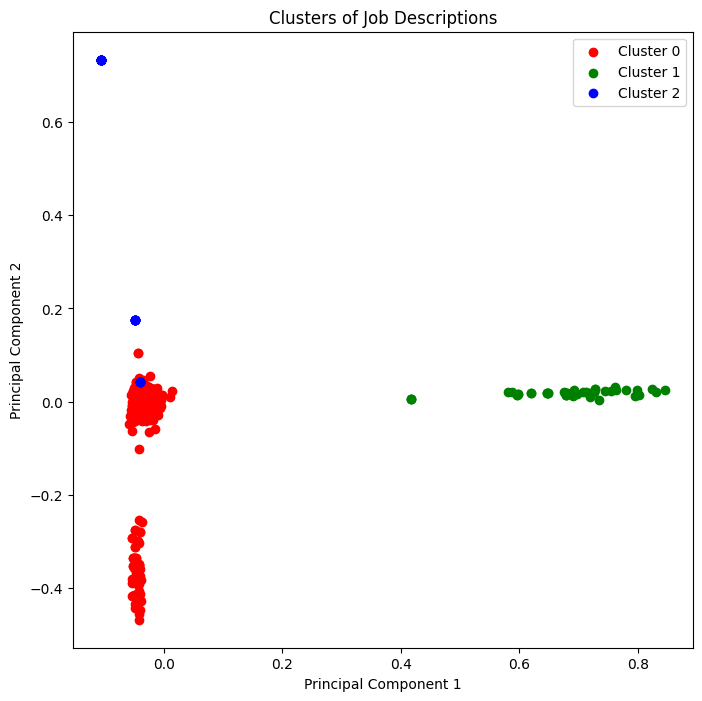

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce the dimensionality of the TF-IDF matrix to 2 dimensions
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf.toarray())

# Plot the data points with different colors for each cluster
plt.figure(figsize=(8, 8))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'gray', 'black', 'pink', 'brown', 'cyan']
for i in range(kmeans.n_clusters):
    plt.scatter(tfidf_2d[kmeans.labels_ == i, 0], tfidf_2d[kmeans.labels_ == i, 1], c=colors[i], label='Cluster {}'.format(i))
plt.legend()
plt.title('Clusters of Job Descriptions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [8]:
# Get the cluster centers in the TF-IDF space
cluster_centers = kmeans.cluster_centers_

# For each cluster, get the top 10 features
n_top_features = 10
for i, center in enumerate(cluster_centers):
    print(f"\nTop {n_top_features} words for cluster {i}:")
    top_features_idx = center.argsort()[::-1][:n_top_features]
    top_features = [feature_names[idx] for idx in top_features_idx]
    print(top_features)


Top 10 words for cluster 0:
['marketing', 'sales', 'project', 'program', 'customers', 'design', 'quality', 'manufacturing', 'status', 'software']

Top 10 words for cluster 1:
['tik tok', 'tik', 'tok', 'paid', 'inspire', 'byte', 'inspire creativity', 'mission inspire creativity', 'premium coverage', 'mission inspire']

Top 10 words for cluster 2:
['intake', 'engineers', 'client', 'patient', 'clinical', 'recruiting scratch', 'scratch', 'companies', '000', 'best product']


In [9]:
# i'm going to try to build the LDA model once again a bit differently
# the change in approach will mostly include change in data preprocessing

job_descriptions = join_dataframes(job_df, description_df)
job_descriptions.drop(columns = 'Job Link_y', inplace = True )

#gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
  
#spacy
import spacy

#vis
import pyLDAvis 
import pyLDAvis.gensim

stopwords = stopwords.words('english')


In [10]:
# let's start preprocessing the data

def lemmatization(texts, allowed_tags = ['NOUN','ADJ','VERB','ADV']):
    nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
    texts_out = []
    for text in texts:
        if not isinstance(text, str):
            print(f"Found non-string element: {text}")
        else:
            tokens = nlp(text)
            lemmas = [token.lemma_ for token in tokens if token.pos_ in allowed_tags]
            texts_out.append(" ".join(lemmas))
    return texts_out

lemmatized_texts = lemmatization(job_descriptions['Job Description'])

In [11]:
import gensim 

def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text)
        final.append(new)
    return final

data_words = gen_words(lemmatized_texts)

In [12]:
# indexing the words and producing tuples (index, frequency)
id2word = corpora.Dictionary(data_words)

corpus = []

for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)


In [13]:
# creating the model 

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 30,
                                            random_state = 50,
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 10,
                                            alpha = 'auto')

In [14]:
# visualizing the otuput

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds = 'mmds', R = 30)
vis

# after visualizing for the 1st time I can see that 1) I used way too high topics value and 2) there are common words like 'more', 'lead' etc. which
# are of no interest to me and I should think about how to remove those 

c:\Users\kaczm\.virtualenvs\python_prj-SRynVlFM\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
c:\Users\kaczm\.virtualenvs\python_prj-SRynVlFM\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.079256  0.258284       1        1  24.453475
13     0.173707  0.347879       2        1  18.870949
18    -0.050774  0.416588       3        1  12.968112
29    -0.000658  0.368909       4        1  10.705198
1      0.448062  0.051879       5        1   6.628226
0      0.337874  0.265276       6        1   5.703573
17     0.156829  0.401074       7        1   4.932973
22    -0.267995  0.329658       8        1   4.603176
4     -0.175180  0.340639       9        1   4.375418
7      0.254646  0.243692      10        1   2.582826
9      0.371112  0.110678      11        1   2.328861
16    -0.342240  0.085199      12        1   0.697294
11    -0.374472 -0.094237      13        1   0.469522
5     -0.258344 -0.043414      14        1   0.315718
10     0.115337 -0.255868      15        1   0.153501
15    -0.114159 -0.199556      16        1   0.064484
26    -0.074805 -0.233527      17        1   0.056644
24    -0.008004 -0.256041      18        1   0.037230
28    -0.010777 -0.176382      19        1   0.012473
20    -0.004077 -0.188071      20        1   0.011123
19    -0.024477 -0.187609      21        1   0.006834
27    -0.024169 -0.176673      22        1   0.005462
3     -0.025837 -0.176047      23        1   0.002189
25    -0.025837 -0.176047      24        1   0.002146
12    -0.025837 -0.176047      25        1   0.002145
23    -0.025837 -0.176047      26        1   0.002132
21    -0.025837 -0.176047      27        1   0.002100
14    -0.025837 -0.176047      28        1   0.002089
6     -0.025837 -0.176047      29        1   0.002066
8     -0.025837 -0.176047      30        1   0.002060, topic_info=             Term         Freq        Total Category  logprob  loglift
229       product  6089.000000  6089.000000  Default  30.0000  30.0000
61          datum  1162.000000  1162.000000  Default  29.0000  29.0000
59       customer  2440.000000  2440.000000  Default  28.0000  28.0000
322       benefit  1464.000000  1464.000000  Default  27.0000  27.0000
233       project  1740.000000  1740.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
25           bill     0.000683     9.963638  Topic30  -9.0493   1.2016
26        billing     0.000683     3.917197  Topic30  -9.0493   2.1351
27   breakthrough     0.000683    24.808802  Topic30  -9.0493   0.2893
28          build     0.000683  1177.629089  Topic30  -9.0493  -3.5707
29       business     0.000683  1751.437052  Topic30  -9.0493  -3.9677

[1826 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.084627  ability
0         2  0.542184  ability
0         3  0.179294  ability
0         4  0.050202  ability
0         5  0.005737  ability
...     ...       ...      ...
312       9  0.018043     year
312      10  0.034582     year
312      11  0.010525     year
312      14  0.003007     year
3049      8  0.980693    yield

[2604 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 14, 19, 30, 2, 1, 18, 23, 5, 8, 10, 17, 12, 6, 11, 16, 27, 25, 29, 21, 20, 28, 4, 26, 13, 24, 22, 15, 7, 9])

In [15]:
# now i am gonna create bigrams/ trigrams as well as remove frequent words that do not bring much to my analysis

from gensim.models.phrases import Phrases, Phraser

# create bigram phrases
bigram_phrases = Phrases(data_words, min_count=5, threshold=80)

# transform the corpus using the bigram phrases
data_bigrams = [bigram_phrases[doc] for doc in data_words]

# create trigram phrases
trigram_phrases = Phrases(data_bigrams, min_count=5, threshold=80)

# transform the corpus using the trigram phrases
data_trigrams = [trigram_phrases[bigram_doc] for bigram_doc in data_bigrams]

# create a Phraser object for the trigram phrases (optional, but recommended for faster processing)
trigram_phraser = Phraser(trigram_phrases)

In [16]:
# now let's remove the frequent unnecessary rows

from gensim.models import TfidfModel

# Create a dictionary of the trigrams in the data
id2word = corpora.Dictionary(data_trigrams)

# Convert the data to a bag-of-words corpus
texts = data_trigrams 
corpus = [id2word.doc2bow(text) for text in texts]

# Compute the TF-IDF scores for the corpus
tfidf = TfidfModel(corpus, id2word=id2word)

# Define a threshold for low-value words
low_value = 0.03

# Initialize lists for storing low-value words and missing words
words = []
words_missing_in_tfidf = []

# Loop over each document in the corpus
for i in range(0, len(corpus)):
    bow = corpus[i]
    
    # Initialize a list for storing low-value words
    low_value_words = []
    
    # Get the IDs of words with nonzero TF-IDF scores
    tfidf_ids = [id for id, value in tfidf[bow]]
    
    # Get the IDs of all words in the document
    bow_ids = [id for id, value in bow]
    
    # Find all words with a TF-IDF score below the threshold
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    
    # Add low-value words and missing words to the list of words to be dropped
    drops = low_value_words + words_missing_in_tfidf
    
    # Add dropped words to the list of words
    for item in drops:
        words.append(id2word[item])
    
    # Find all words that are missing from the TF-IDF model
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    
    # Remove all low-value and missing words from the document
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    
    # Replace the original document with the cleaned-up version
    corpus[i] = new_bow


In [17]:
# create new model

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 20,
                                            random_state = 50,
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 10,
                                            alpha = 'auto')


In [18]:
#visualize it

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds = 'mmds', R = 30)
vis

#looks much better now


c:\Users\kaczm\.virtualenvs\python_prj-SRynVlFM\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
c:\Users\kaczm\.virtualenvs\python_prj-SRynVlFM\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19     0.210495 -0.111924       1        1  24.470372
11     0.370981  0.034374       2        1  13.440189
10    -0.108232 -0.210228       3        1  10.820104
8     -0.388372 -0.143136       4        1   8.129546
9      0.141036 -0.379143       5        1   7.418469
3     -0.112153 -0.366086       6        1   6.051928
16    -0.302761 -0.320646       7        1   5.181753
7      0.068166 -0.280118       8        1   5.050038
4      0.352489  0.266821       9        1   4.609583
1      0.303364 -0.269060      10        1   4.168571
0      0.411547 -0.078590      11        1   3.871434
13     0.011771  0.416726      12        1   2.399660
15     0.177202  0.272905      13        1   2.127143
6     -0.328440  0.199308      14        1   0.810832
12    -0.048435  0.240403      15        1   0.519814
18    -0.175957  0.250328      16        1   0.372627
17    -0.238414  0.081157      17        1   0.309498
2     -0.147890  0.130401      18        1   0.134012
5     -0.088276  0.144099      19        1   0.102515
14    -0.108120  0.122408      20        1   0.011912, topic_info=             Term         Freq        Total Category  logprob  loglift
221       project  1195.000000  1195.000000  Default  30.0000  30.0000
304       benefit   963.000000   963.000000  Default  29.0000  29.0000
246          sale   796.000000   796.000000  Default  28.0000  28.0000
55       customer  1886.000000  1886.000000  Default  27.0000  27.0000
234   requirement   524.000000   524.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
4000         pull     0.002173     0.894907  Topic20  -9.1598   3.0149
4128      weekend     0.002173     0.894875  Topic20  -9.1598   3.0149
4233      complie     0.002173     0.894871  Topic20  -9.1598   3.0149
4541        pound     0.002173     0.894883  Topic20  -9.1598   3.0149
5358   perception     0.002173     0.894862  Topic20  -9.1598   3.0149

[1188 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.012775      ability
0         3  0.007665      ability
0         6  0.076648      ability
0         8  0.127747      ability
0         9  0.774147      ability
...     ...       ...          ...
3082      9  0.871466     workshop
944       2  0.868206  world_class
944       9  0.121145  world_class
3335      7  0.973444        yield
1243     11  0.872171       you_re

[2185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 12, 11, 9, 10, 4, 17, 8, 5, 2, 1, 14, 16, 7, 13, 19, 18, 3, 6, 15])

In [190]:
# let's also do lda model with word embeddings insteaf of bag od words

# generally, word emebeddings can work better when the data has complex relationships between words: For example, word embeddings can be useful 
# for natural language processing tasks where the meaning of a word depends on its context within a sentence or document.
# let's see if there's sense in using it here

corpus = [" ".join(doc) for doc in texts]

from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.word2vec import Word2Vec

# Build a word2vec model using your corpus
model_w2v = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)

# Build a gensim dictionary using your corpus
processed_corpus = [doc.split() for doc in corpus] # split the string into tokens
dictionary = Dictionary(processed_corpus)

# Convert the corpus into bag-of-words format
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_corpus]

# Train an LDA model on the bag-of-words corpus
num_topics = 10 # change this value to set the desired number of topics
lda_model = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary)

# Print the topics and their top terms
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')


# after several tries i don't think it makes sense this case



Topic: 0 
Words: 0.027*"product" + 0.015*"experience" + 0.014*"work" + 0.011*"team" + 0.010*"customer" + 0.006*"build" + 0.006*"include" + 0.006*"business" + 0.006*"other" + 0.006*"company"

Topic: 1 
Words: 0.015*"product" + 0.014*"team" + 0.014*"experience" + 0.013*"customer" + 0.013*"work" + 0.006*"drive" + 0.006*"skill" + 0.006*"management" + 0.006*"include" + 0.006*"business"

Topic: 2 
Words: 0.016*"product" + 0.013*"experience" + 0.011*"include" + 0.010*"work" + 0.010*"team" + 0.009*"customer" + 0.007*"support" + 0.007*"development" + 0.006*"skill" + 0.006*"program"

Topic: 3 
Words: 0.015*"experience" + 0.013*"team" + 0.011*"work" + 0.010*"product" + 0.008*"include" + 0.007*"year" + 0.006*"skill" + 0.006*"provide" + 0.005*"customer" + 0.005*"company"

Topic: 4 
Words: 0.015*"experience" + 0.012*"work" + 0.012*"include" + 0.012*"team" + 0.011*"project" + 0.011*"product" + 0.008*"benefit" + 0.007*"business" + 0.006*"management" + 0.006*"plan"

Topic: 5 
Words: 0.017*"product" + 0

In [ ]:
#stary kod pod deskrypcje, zostawiam na wszelki wielki
'''description_df = pd.DataFrame(columns = ['Description', 'Job Link'])

def get_description(webpage, page_number, description_df):
    next_page = webpage + str(page_number)
    response = requests.get(str(next_page))
    soup = BeautifulSoup(response.content,'html.parser')
    url_deep = []

    for a in soup.find_all('a', class_='base-card__full-link absolute top-0 right-0 bottom-0 left-0 p-0 z-[2]',href=True):
        url_deep.append(a['href'])

    for u in url_deep:
    # Make a request to the second page
        response_deep = requests.get(u)

    # Find all description elements
        sub_soup=BeautifulSoup(response_deep.content,features="lxml")
        text1=sub_soup.findAll("div", {"class": "description__text description__text--rich"})

        for s in text1:
            description = s.text
            description_df = description_df.append({'Description': description, 'Job Link': u}, ignore_index=True)
    return description_df        

get_description('https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=data%20science&location=Stany%20Zjednoczone&geoId=103644278&trk=public_jobs_jobs-search-bar_search-submit&position=1&pageNum=0&start=',0, description_df)'''

'''import pandas as pd
import re

soup = BeautifulSoup(response.content,'html.parser')

description_df = pd.DataFrame(columns = ['Description'])


url_deep = []
for a in soup.find_all('a', class_='base-card__full-link absolute top-0 right-0 bottom-0 left-0 p-0 z-[2]',href=True):
    url_deep.append(a['href'])
    
redundancy_character=['</em>','</p>','<p>','<em>','<trong>','</li>','<li>','<div class="description__text description__text--rich">',
                      '</ul>','<ul>','<u>','</u>','</div>', '<br>','</br>','<br/>','<br/>'] 

for u in url_deep:
    # Make a request to the second page
    response_deep = requests.get(u)

    # Find all description elements
    sub_soup=BeautifulSoup(response_deep.content,features="lxml")
    text1=sub_soup.findAll("div", {"class": "description__text description__text--rich"})

    for s in text1:
        description = s.text
        description_df = description_df.append({'Description': description}, ignore_index=True)'''

,Job Title,Job Link_x,Job Description,Job Link_y
0,Director Product Management - Feed,https://www.linkedin.com/jobs/view/director-pr...,\n\n\nCompany DescriptionLinkedIn was built to...,https://www.linkedin.com/jobs/view/director-pr...
1,"Vice President - Product Strategy, Chief of Staff",https://www.linkedin.com/jobs/view/vice-presid...,\n\n\nCompany DescriptionFreshworks makes it f...,https://www.linkedin.com/jobs/view/vice-presid...
2,"Senior Director, Product Management, Labs",https://www.linkedin.com/jobs/view/senior-dire...,\n\n\n Applications will be accepted th...,https://www.linkedin.com/jobs/view/senior-dire...
3,Director of Product Management,https://www.linkedin.com/jobs/view/director-of...,\n\n\nAbout Lyra HealthLyra is transforming me...,https://www.linkedin.com/jobs/view/director-of...
4,Global Head of Product Management,https://www.linkedin.com/jobs/view/global-head...,\n\n\n EA SPORTS is one of the most ico...,https://www.linkedin.com/jobs/view/global-head...
5,Global Head of Product Management,https://www.linkedin.com/jobs/view/global-head...,\n\n\n EA SPORTS is one of the most ico...,https://www.linkedin.com/jobs/view/global-head...
6,Head of Product,https://www.linkedin.com/jobs/view/head-of-pro...,"\n\n\nAbout FarmWise:At FarmWise, we harness t...",https://www.linkedin.com/jobs/view/head-of-pro...
7,Head of Product Management,https://www.linkedin.com/jobs/view/head-of-pro...,\n\n\nWell-funded series A startup looking to ...,https://www.linkedin.com/jobs/view/head-of-pro...
8,Head of Business Operations - Games Operations,https://www.linkedin.com/jobs/view/head-of-bus...,\n\n\n Netflix is looking for an experi...,https://www.linkedin.com/jobs/view/head-of-bus...
9,"Product Owner, Data and Analytics - Remote",https://www.linkedin.com/jobs/view/product-own...,"\n\n\n PayNearMe, a service of Handle F...",https://www.linkedin.com/jobs/view/product-own...
